In [1]:
import json, sys, time, os, copy

import matplotlib as mpl
import seaborn as sns
import pandas
import pickle
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.nn.init import xavier_uniform_, zeros_
from PyQt5.QtWidgets import QApplication
from torchvision.models import vgg16_bn

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score

from datasets import Train_Meta_Dataset, Val_Meta_Dataset, Test_Meta_Dataset, Random_Affine, ToTensor, Normalise, collate_fn
from meta_function import meta_loading
from train_utils import get_device_metrics

## VGG

In [2]:
# fileDir = "C:/fully_split_data/"
# t1MapDir = "C:/T1_Maps/"
fileDir = "/media/storage/chill/fully_split_data/"
t1MapDir = "/media/storage/chill/T1_Maps/"

modelName = "Not_Norm_20000_Cardiov"
normQ = False

modelDir = "./models/VGG_16/{}/".format(modelName)
assert os.path.isdir(modelDir), "Model Directory is not found, please check your model name!"


figDir = "{}Test_Figures/".format(modelDir)
try:
    os.makedirs(figDir)
except FileExistsError as e:
    print(e, "This means you will be overwriting previous results!")

toT = ToTensor()

if normQ:
    norm = Normalise()
    trnsInTest = transforms.Compose([toT,norm])
else:
    trnsInTest = transforms.Compose([toT])

[Errno 17] File exists: './models/VGG_16/Not_Norm_20000_Cardiov/Test_Figures/' This means you will be overwriting previous results!


In [3]:
condense = False
datasetTest = Test_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=1000,transform=trnsInTest,load=True,condense=condense)


 Loading Meta Data.... 

 [31199/31199]


In [4]:
bSize = 2
loaderTest = DataLoader(datasetTest,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

batch = next(iter(loaderTest))
inpMetaSize = batch['Meta'].size()[1]
if condense:
    outSize = 1
else:
    outSize = batch["Tag"].size()[1]

In [5]:
deviceMetrics, sugDev = get_device_metrics()

device = torch.device(sugDev if torch.cuda.is_available() else "cpu")

print("Running on device: {}".format(device))

net = vgg16_bn(pretrained=False)
numFtrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(numFtrs,outSize)
numChannels = net.features[0].out_channels
net.features[0] = nn.Conv2d(7, numChannels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

modelDict = torch.load("{}model.pt".format(modelDir),map_location=device)
net.load_state_dict(modelDict["state_dict"])
net = net.to(device)

testLen = datasetTest.__len__()

testLossCnt = 0

Running on device: cuda:1


In [6]:
pred = np.zeros((testLen,outSize))
y_test_full = np.zeros((testLen,outSize))
rfData_test = np.zeros((testLen,inpMetaSize))
with torch.no_grad():
    net.eval()
    for i,data in enumerate(loaderTest):
        inpData = data["Images"].to(device)

        rfData_test[i*bSize:(i+1)*bSize,:] = data["Meta"].numpy()
        y_test_full[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()

        out = net(inpData)

        out = torch.sigmoid(out)

        pred[i*bSize:(i+1)*bSize,:] = out.cpu().numpy()

        sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,testLen))

	Subj 4998/5000

In [7]:
print(pred)

[[1.11340673e-03 2.70698947e-05 2.27892684e-04 ... 1.94929179e-03
  1.98100125e-07 7.00759876e-04]
 [7.71173509e-05 4.77349477e-06 2.13179555e-05 ... 7.66091980e-04
  1.26479038e-09 3.48835805e-04]
 [2.04507019e-02 4.37334129e-05 2.11158395e-03 ... 2.93944287e-03
  1.18256452e-04 3.03125568e-03]
 ...
 [4.93090716e-04 1.65801630e-05 1.21676865e-04 ... 1.14030065e-03
  4.52864732e-08 3.50911636e-04]
 [3.49211157e-04 1.32879368e-05 9.67549131e-05 ... 1.75436214e-03
  3.00587999e-08 8.28542397e-04]
 [1.69970095e-02 3.05725291e-04 5.85207157e-03 ... 8.96836724e-03
  8.54932296e-04 2.94011901e-03]]


## Random Forest

In [8]:
# Hyperparameters:
n_estimators = 100
max_depth = 10
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
numAvgs = np.arange(0,20,1)

In [9]:
# Setup Train set for random forest
datasetTrain = Train_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=1000,transform=trnsInTest,load=True,condense=condense)
loaderTrain = DataLoader(datasetTrain,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

trainLen = datasetTrain.__len__()

rfData_train = np.zeros((trainLen,inpMetaSize))
y_train_full = np.zeros((trainLen,outSize))

for i,data in enumerate(loaderTrain):
    rfData_train[i*bSize:(i+1)*bSize,:] = data["Meta"].numpy()
    y_train_full[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()
    sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,trainLen))

# Setup Validation set for random forest
datasetVal = Val_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=1000,transform=trnsInTest,load=True,condense=condense)
loaderVal = DataLoader(datasetVal,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

valLen = datasetVal.__len__()

rfData_val = np.zeros((valLen,inpMetaSize))
y_val_full = np.zeros((valLen,outSize))

for i,data in enumerate(loaderVal):
    rfData_val[i*bSize:(i+1)*bSize,:] = data["Meta"].numpy()
    y_val_full[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()
    sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,valLen))



 Loading Meta Data.... 

 [31199/31199]
	Subj 19998/20000
 Loading Meta Data.... 

 [31199/31199]
	Subj 4998/5000

In [10]:
metricsDict = {}
clfDict = {}
topAUC = {}

for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y_train = y_train_full[:,idx]
        X_train = rfData_train[:,:]

        clf.fit(X_train, y_train)

        X_test = rfData_val
        y_test = y_val_full[:,idx]

        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [11]:
probs = np.zeros((testLen,outSize))
for idx,name in enumerate(tagNames):
    clf = clfDict[name]

    X_test = rfData_test
    y_test = y_test_full[:,idx]

    score = clf.score(X_test, y_test)
    probs[:,idx] = clf.predict_proba(X_test)[:,1]


In [12]:
probs

array([[1.33262294e-03, 0.00000000e+00, 9.99533444e-04, ...,
        6.83531097e-04, 7.35795539e-06, 9.33554081e-05],
       [1.75665332e-04, 0.00000000e+00, 1.05445401e-02, ...,
        6.75222908e-04, 2.19533278e-06, 6.51902420e-04],
       [7.40259251e-03, 0.00000000e+00, 1.67138287e-03, ...,
        1.13652514e-02, 2.00621270e-02, 4.37423990e-03],
       ...,
       [5.15664133e-04, 0.00000000e+00, 2.61259041e-03, ...,
        1.57152376e-03, 1.61434277e-06, 9.63117677e-04],
       [3.73534096e-04, 0.00000000e+00, 4.02292500e-04, ...,
        6.74841925e-04, 2.19533278e-06, 9.77436055e-05],
       [9.02662770e-03, 0.00000000e+00, 7.62775821e-04, ...,
        1.88916894e-03, 1.06581306e-04, 5.54231441e-04]])

# COMBINED

In [13]:
print(probs.shape)


(5000, 12)


In [14]:
print(pred.shape)

(5000, 12)


In [15]:
overallPred = probs*pred

In [16]:
overallPred

array([[1.48375135e-06, 0.00000000e+00, 2.27786359e-07, ...,
        1.33240156e-06, 1.45761188e-12, 6.54197242e-08],
       [1.35468451e-08, 0.00000000e+00, 2.24788038e-07, ...,
        5.17282855e-07, 2.77663578e-15, 2.27406906e-07],
       [1.51388213e-04, 0.00000000e+00, 3.52926523e-06, ...,
        3.34075072e-05, 2.37247596e-06, 1.32594395e-05],
       ...,
       [2.54269197e-07, 0.00000000e+00, 3.17891811e-07, ...,
        1.79200957e-06, 7.31078906e-14, 3.37969199e-07],
       [1.30442274e-07, 0.00000000e+00, 3.89237759e-08, ...,
        1.18391712e-06, 6.59890686e-14, 8.09847212e-08],
       [1.53425677e-04, 0.00000000e+00, 4.46381870e-06, ...,
        1.69427609e-05, 9.11198004e-08, 1.62950640e-06]])

In [17]:
modelsArr = []
fprArr = []
tprArr = []

for idx,name in enumerate(tagNames):
    fpr,tpr,thresh = roc_curve(y_test_full[:,idx],overallPred[:,idx])
    auc_score = roc_auc_score(y_test_full[:,idx],overallPred[:,idx])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})



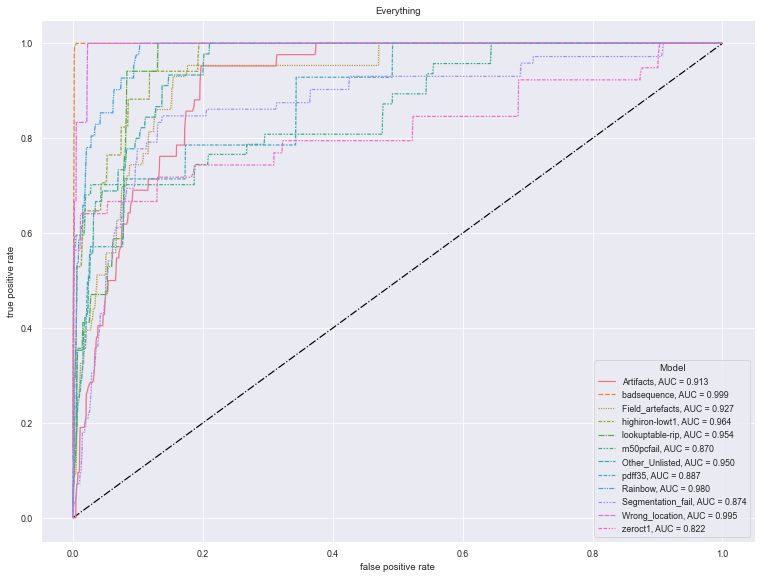

In [18]:
plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

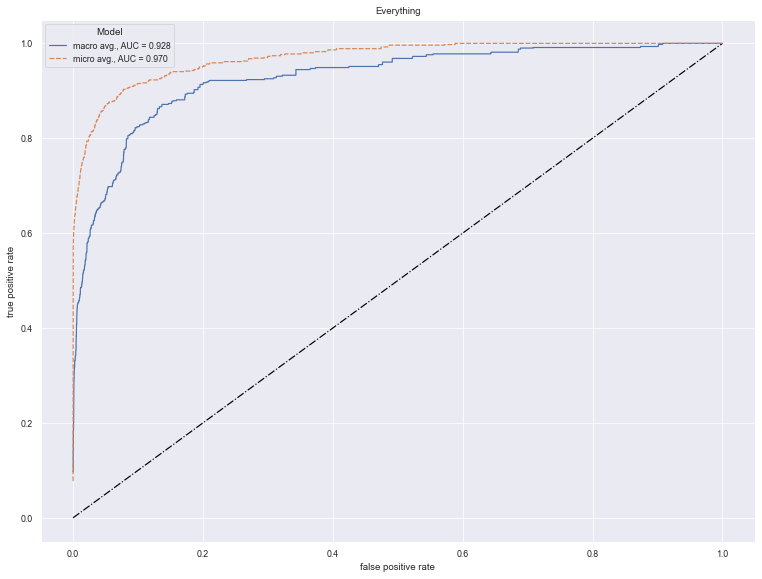

In [25]:
from sklearn.metrics import auc

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
# tagNames = ["Include_Exclude"]

fprDict = {}
tprDict = {}
rocDict = {}
for i,name in enumerate(tagNames):
    fprDict[name], tprDict[name], _ = roc_curve(y_test_full[:,i],overallPred[:,i])
    rocDict[name] = roc_auc_score(y_test_full[:,i],overallPred[:,i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fprDict[name] for name in tagNames]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for name in tagNames:
    mean_tpr += np.interp(all_fpr, fprDict[name], tprDict[name])

# Finally average it and compute AUC
mean_tpr /= len(tagNames)
auc_score = auc(all_fpr,mean_tpr)
event = ["{}, AUC = {:.3f}".format("macro avg.",auc_score)]*(all_fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(all_fpr)
tprArr.extend(mean_tpr)

fpr,tpr,_ = roc_curve(y_test_full.ravel(),overallPred.ravel())
auc_score = roc_auc_score(y_test_full.ravel(),overallPred.ravel())

event = ["{}, AUC = {:.3f}".format("micro avg.",auc_score)]*(fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(fpr)
tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()

In [19]:
modelsArr = []
fprArr = []
tprArr = []

for idx,name in enumerate(tagNames):
    fpr,tpr,thresh = roc_curve(y_test_full[:,idx],pred[:,idx])
    auc_score = roc_auc_score(y_test_full[:,idx],pred[:,idx])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

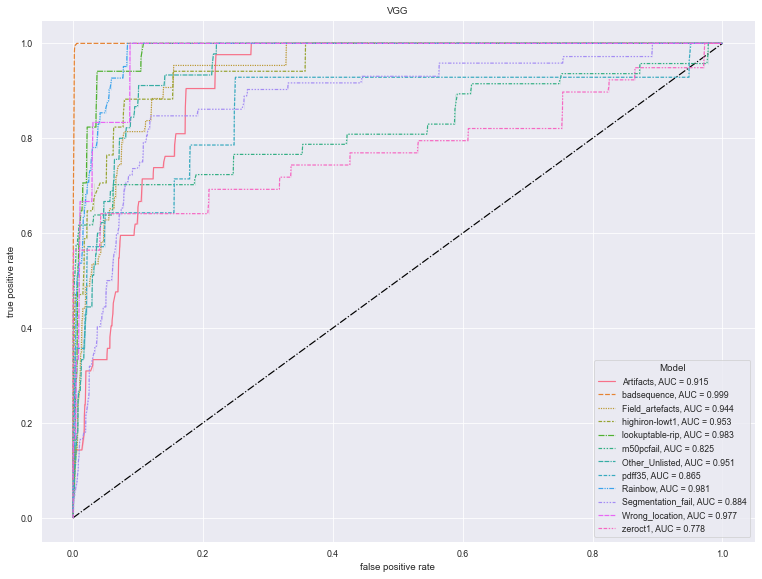

In [20]:
plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

plt.figure()
plt.title("VGG")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

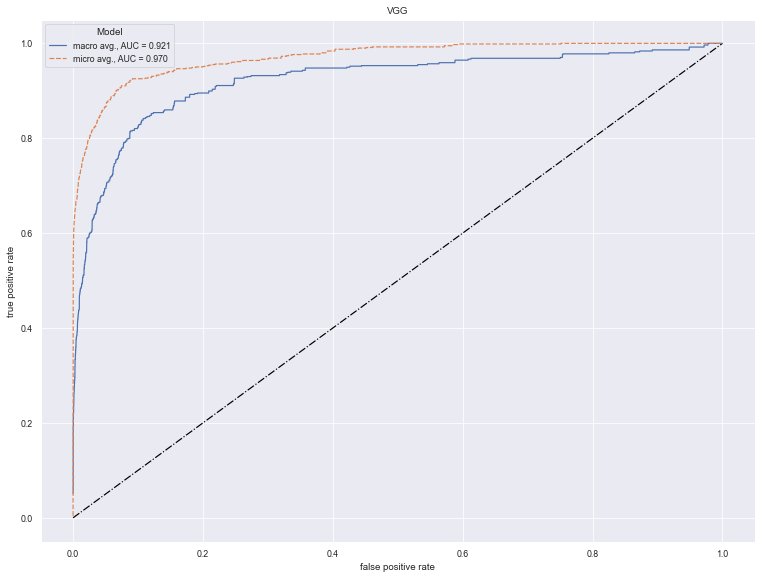

In [26]:
plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
# tagNames = ["Include_Exclude"]

fprDict = {}
tprDict = {}
rocDict = {}
for i,name in enumerate(tagNames):
    fprDict[name], tprDict[name], _ = roc_curve(y_test_full[:,i],pred[:,i])
    rocDict[name] = roc_auc_score(y_test_full[:,i],pred[:,i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fprDict[name] for name in tagNames]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for name in tagNames:
    mean_tpr += np.interp(all_fpr, fprDict[name], tprDict[name])

# Finally average it and compute AUC
mean_tpr /= len(tagNames)
auc_score = auc(all_fpr,mean_tpr)
event = ["{}, AUC = {:.3f}".format("macro avg.",auc_score)]*(all_fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(all_fpr)
tprArr.extend(mean_tpr)

fpr,tpr,_ = roc_curve(y_test_full.ravel(),pred.ravel())
auc_score = roc_auc_score(y_test_full.ravel(),pred.ravel())

event = ["{}, AUC = {:.3f}".format("micro avg.",auc_score)]*(fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(fpr)
tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("VGG")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()

In [21]:
modelsArr = []
fprArr = []
tprArr = []

for idx,name in enumerate(tagNames):
    fpr,tpr,thresh = roc_curve(y_test_full[:,idx],probs[:,idx])
    auc_score = roc_auc_score(y_test_full[:,idx],probs[:,idx])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

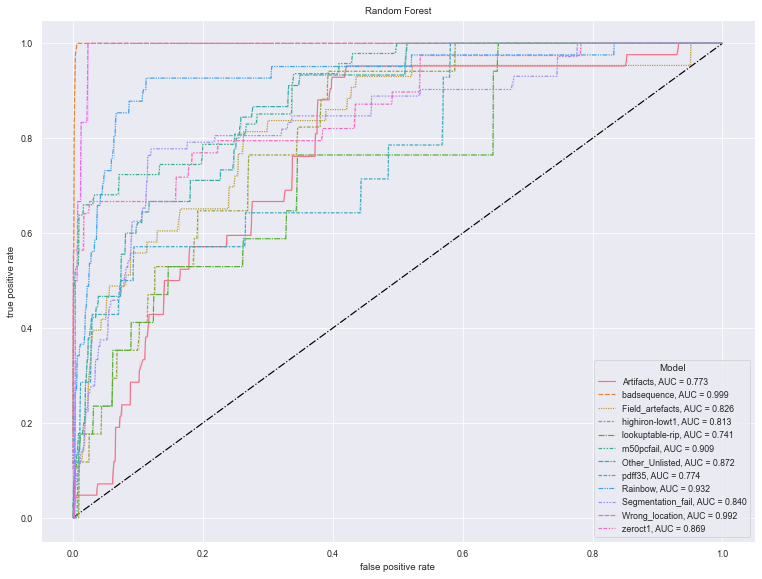

In [22]:
plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

plt.figure()
plt.title("Random Forest")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

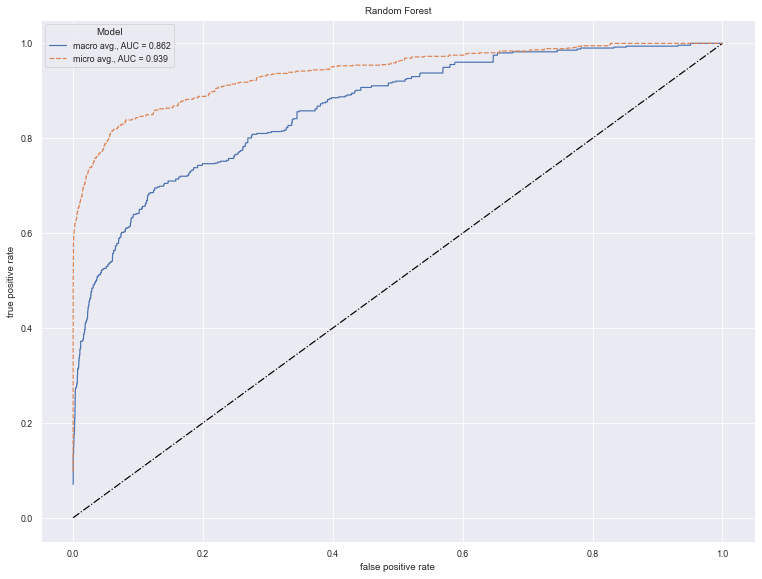

In [27]:
plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
# tagNames = ["Include_Exclude"]

fprDict = {}
tprDict = {}
rocDict = {}
for i,name in enumerate(tagNames):
    fprDict[name], tprDict[name], _ = roc_curve(y_test_full[:,i],probs[:,i])
    rocDict[name] = roc_auc_score(y_test_full[:,i],probs[:,i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fprDict[name] for name in tagNames]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for name in tagNames:
    mean_tpr += np.interp(all_fpr, fprDict[name], tprDict[name])

# Finally average it and compute AUC
mean_tpr /= len(tagNames)
auc_score = auc(all_fpr,mean_tpr)
event = ["{}, AUC = {:.3f}".format("macro avg.",auc_score)]*(all_fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(all_fpr)
tprArr.extend(mean_tpr)

fpr,tpr,_ = roc_curve(y_test_full.ravel(),probs.ravel())
auc_score = roc_auc_score(y_test_full.ravel(),probs.ravel())

event = ["{}, AUC = {:.3f}".format("micro avg.",auc_score)]*(fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(fpr)
tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Random Forest")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()